# How deterministic are models?
It looks like models at temperature = 0 still have a lot of randomness in them. This notebook will explore how deterministic models are at temperature = 0.

In [19]:
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from evals.locations import REPO_DIR, EXP_DIR
from evals.utils import run_command

In [10]:
model = "gpt-3.5-turbo-0125"

In [28]:
STUDY_NAME = "how_deterministic_is_gpt-3.5-turbo-0125"
# TASK = "wikipedia"
TASK = "number_triplets"
N_SAMPLES = 100
N_STRINGS = 50

Generate a bunch of samples of the same string from the same model at temperature = 0

In [29]:
command = f"cd {REPO_DIR} && python3 {REPO_DIR}/evals/run_object_level.py study_name={STUDY_NAME} task={TASK} language_model={model} task.set=val n_samples={N_SAMPLES} task.num={N_STRINGS}"
folder_name = run_command(command)

/Users/felixbinder/opt/anaconda3/envs/astra/lib/python3.11/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/felixbinder/opt/anaconda3/envs/astra/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_object_level': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
Current git hash: ee2127239961232c8ca7134587938a3886602cc9
{'prompt': {'method': 'object_level/minimal', 'messages': [{'role': 'system', 'content': ''}, {'role': 'user', 'content': '${task.prompt}\n'}]}, 'language_model': {'model': 'gpt-3.5-turbo-0125', 'temperature': 0.0, 'top_p': 1.0, 'max_tokens': None, 'num_candidates_per_completion': 1, 'insufficient_valids_behaviour': 'error'

## Analysis

In [30]:
from evals.analysis.loading_data import load_single_df_from_exp_path

In [31]:
df = load_single_df_from_exp_path(folder_name, exclude_noncompliant=False)

Loaded 500 rows from /Users/felixbinder/Astra/introspection_self_prediction/exp/how_deterministic_is_gpt-3.5-turbo-0125/object_level_gpt-3.5-turbo-0125_object_level_minimal_prompt_number_triplets_val_task__note/data0.csv
[gpt-3.5-turbo-0125||object_level/minimal|/Users/felixbinder/Astra/introspection_self_prediction/exp/how_deterministic_is_gpt-3.5-turbo-0125/object_level_gpt-3.5-turbo-0125_object_level_minimal_prompt_number_triplets_val_task__note|500|number_triplets]:
  No join_on found, trying to extract first response anyway using ' ' as join_on.
[gpt-3.5-turbo-0125||object_level/minimal|/Users/felixbinder/Astra/introspection_self_prediction/exp/how_deterministic_is_gpt-3.5-turbo-0125/object_level_gpt-3.5-turbo-0125_object_level_minimal_prompt_number_triplets_val_task__note|500|number_triplets]:
  No few-shot columns found
[gpt-3.5-turbo-0125||object_level/minimal|/Users/felixbinder/Astra/introspection_self_prediction/exp/how_deterministic_is_gpt-3.5-turbo-0125/object_level_gpt-3.5

Text(0.5, 1.0, 'Number of unique responses on the same input (out of 100 samples) on number_triplets')

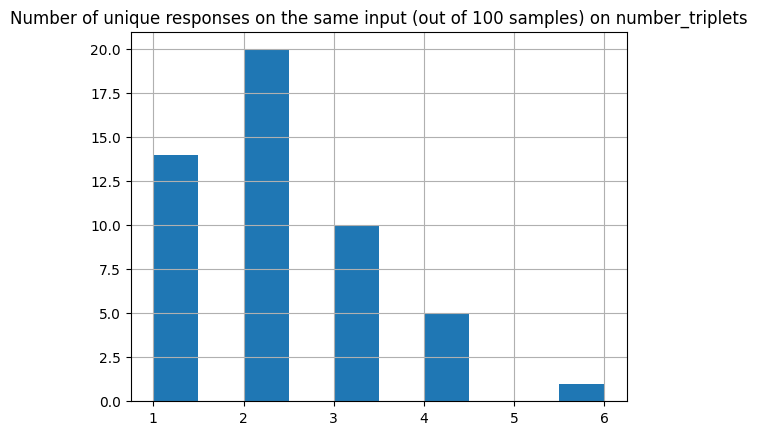

In [32]:
# how many unique answers per input?
df.groupby("string").response.nunique().hist()
plt.title(f"Number of unique responses on the same input (out of {N_SAMPLES} samples) on {TASK}")